In [ ]:
pip install seaborn

In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings

from transformers import BertTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
import torch 

torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('tiktokpre2.csv')
df.head()

,content,sentiment
0,tolong keuangan transfer rekening berbeda reke...,negative
1,sumpah ya aplikasi seller buruk tuh duitnya la...,negative
2,susah ribet,negative
3,capai bikin dekripsi tolak kacau,negative
4,pelanggaran upload barang,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    3145 non-null   object
 1   sentiment  3145 non-null   object
dtypes: object(2)
memory usage: 49.3+ KB


In [5]:
df = df.rename(columns={'content': 'review'})

In [6]:
df.head()

,review,sentiment
0,tolong keuangan transfer rekening berbeda reke...,negative
1,sumpah ya aplikasi seller buruk tuh duitnya la...,negative
2,susah ribet,negative
3,capai bikin dekripsi tolak kacau,negative
4,pelanggaran upload barang,negative


In [7]:
df['sentiment'].replace({'positive': 1, 'negative': 0}, inplace=True)
df.head()

,review,sentiment
0,tolong keuangan transfer rekening berbeda reke...,0
1,sumpah ya aplikasi seller buruk tuh duitnya la...,0
2,susah ribet,0
3,capai bikin dekripsi tolak kacau,0
4,pelanggaran upload barang,0


In [8]:
frequency = df['sentiment'].value_counts()
print(frequency)

sentiment
0    1755
1    1390
Name: count, dtype: int64


In [9]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [10]:
print("Jumlah data train:", train_df.shape[0])
print("Jumlah data val:", val_df.shape[0])
print("Jumlah data test:", test_df.shape[0])

Jumlah data train: 2012
Jumlah data val: 504
Jumlah data test: 629


In [11]:
# Tokenization
from transformers import BertTokenizer, AutoModel
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-base-p2")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.


In [12]:
class SentimentDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [13]:
# Prepare DataLoader for training data
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SentimentDataset(
    reviews=train_df.review.to_numpy(),
    targets=train_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Prepare DataLoader for validation data
val_dataset = SentimentDataset(
    reviews=val_df.review.to_numpy(),
    targets=val_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Prepare DataLoader for test data
test_dataset = SentimentDataset(
    reviews=test_df.review.to_numpy(),
    targets=test_df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Define model
model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-lite-base-p2', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-7)

In [16]:
# Parameters
EPOCHS = 37
loss_fn = CrossEntropyLoss().to(device)

# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.logits.argmax(dim=-1)
        correct_train_predictions += (predictions == targets).sum().item()
        total_train_samples += targets.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = outputs.loss

        total_val_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.logits.argmax(dim=-1)
        correct_val_predictions += (predictions == targets).sum().item()
        total_val_samples += targets.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_predictions / total_val_samples
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss} - Validation Loss: {avg_val_loss}")
    print(f"Epoch {epoch + 1} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 1 - Train Loss: 0.7874560715660216 - Validation Loss: 0.7573061194270849
Epoch 1 - Train Accuracy: 0.4388667992047714 - Validation Accuracy: 0.49603174603174605


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch 2 - Train Loss: 0.7230791501582615 - Validation Loss: 0.6975161600857973
Epoch 2 - Train Accuracy: 0.5064612326043738 - Validation Accuracy: 0.5178571428571429


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 3 - Train Loss: 0.6752597770047566 - Validation Loss: 0.646567914634943
Epoch 3 - Train Accuracy: 0.5864811133200796 - Validation Accuracy: 0.6130952380952381


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.46it/s]


Epoch 4 - Train Loss: 0.6254335868926275 - Validation Loss: 0.6023775544017553
Epoch 4 - Train Accuracy: 0.6530815109343936 - Validation Accuracy: 0.753968253968254


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 5 - Train Loss: 0.5847129705879424 - Validation Loss: 0.5633257096633315
Epoch 5 - Train Accuracy: 0.7549701789264414 - Validation Accuracy: 0.7976190476190477


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.42it/s]


Epoch 6 - Train Loss: 0.5520187351438735 - Validation Loss: 0.5265971003100276
Epoch 6 - Train Accuracy: 0.7952286282306164 - Validation Accuracy: 0.8313492063492064


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.41it/s]


Epoch 7 - Train Loss: 0.5155017054270185 - Validation Loss: 0.49332983884960413
Epoch 7 - Train Accuracy: 0.8151093439363817 - Validation Accuracy: 0.8392857142857143


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.41it/s]


Epoch 8 - Train Loss: 0.48897567036606016 - Validation Loss: 0.46445759385824203
Epoch 8 - Train Accuracy: 0.831013916500994 - Validation Accuracy: 0.8492063492063492


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.38it/s]


Epoch 9 - Train Loss: 0.46059239005285596 - Validation Loss: 0.44006154872477055
Epoch 9 - Train Accuracy: 0.8369781312127237 - Validation Accuracy: 0.8551587301587301


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.37it/s]


Epoch 10 - Train Loss: 0.43951338364018333 - Validation Loss: 0.4194157486781478
Epoch 10 - Train Accuracy: 0.8449304174950298 - Validation Accuracy: 0.8611111111111112


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 11 - Train Loss: 0.4233122318983078 - Validation Loss: 0.4013188970275223
Epoch 11 - Train Accuracy: 0.8503976143141153 - Validation Accuracy: 0.8670634920634921


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 12 - Train Loss: 0.406871800857877 - Validation Loss: 0.3843914628960192
Epoch 12 - Train Accuracy: 0.8518886679920478 - Validation Accuracy: 0.873015873015873


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch 13 - Train Loss: 0.387745732234584 - Validation Loss: 0.36899253726005554
Epoch 13 - Train Accuracy: 0.8648111332007953 - Validation Accuracy: 0.8829365079365079


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.29it/s]


Epoch 14 - Train Loss: 0.37059194310790017 - Validation Loss: 0.35309316916391253
Epoch 14 - Train Accuracy: 0.8762425447316103 - Validation Accuracy: 0.8928571428571429


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.38it/s]


Epoch 15 - Train Loss: 0.35673315823078156 - Validation Loss: 0.3399140848778188
Epoch 15 - Train Accuracy: 0.8802186878727635 - Validation Accuracy: 0.8948412698412699


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch 16 - Train Loss: 0.34372478841789184 - Validation Loss: 0.3249086285941303
Epoch 16 - Train Accuracy: 0.8866799204771372 - Validation Accuracy: 0.9047619047619048


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 17 - Train Loss: 0.3286615713011651 - Validation Loss: 0.31223281333222985
Epoch 17 - Train Accuracy: 0.8916500994035785 - Validation Accuracy: 0.9067460317460317


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.32it/s]


Epoch 18 - Train Loss: 0.31865465499105905 - Validation Loss: 0.2992188506759703
Epoch 18 - Train Accuracy: 0.8966202783300199 - Validation Accuracy: 0.9067460317460317


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 19 - Train Loss: 0.3069442573284346 - Validation Loss: 0.2880028239451349
Epoch 19 - Train Accuracy: 0.904572564612326 - Validation Accuracy: 0.9126984126984127


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.33it/s]


Epoch 20 - Train Loss: 0.29315313413029626 - Validation Loss: 0.27781544625759125
Epoch 20 - Train Accuracy: 0.9070576540755467 - Validation Accuracy: 0.9186507936507936


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.31it/s]


Epoch 21 - Train Loss: 0.2845840670523189 - Validation Loss: 0.2679407703690231
Epoch 21 - Train Accuracy: 0.9100397614314115 - Validation Accuracy: 0.9246031746031746


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 22 - Train Loss: 0.27398275915119386 - Validation Loss: 0.2599275487009436
Epoch 22 - Train Accuracy: 0.9179920477137177 - Validation Accuracy: 0.9246031746031746


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 23 - Train Loss: 0.26470576498716597 - Validation Loss: 0.2523075130302459
Epoch 23 - Train Accuracy: 0.9224652087475149 - Validation Accuracy: 0.9246031746031746


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch 24 - Train Loss: 0.25821713553298087 - Validation Loss: 0.24491469841450453
Epoch 24 - Train Accuracy: 0.9234592445328031 - Validation Accuracy: 0.9325396825396826


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 25 - Train Loss: 0.24949270847534377 - Validation Loss: 0.23845125432126224
Epoch 25 - Train Accuracy: 0.9259443339960238 - Validation Accuracy: 0.9345238095238095


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 26 - Train Loss: 0.24183221102233918 - Validation Loss: 0.23329785792157054
Epoch 26 - Train Accuracy: 0.929920477137177 - Validation Accuracy: 0.9384920634920635


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 27 - Train Loss: 0.23533053932681916 - Validation Loss: 0.22753236070275307
Epoch 27 - Train Accuracy: 0.9324055666003976 - Validation Accuracy: 0.9404761904761905


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 28 - Train Loss: 0.22983808939655623 - Validation Loss: 0.22260701400227845
Epoch 28 - Train Accuracy: 0.9324055666003976 - Validation Accuracy: 0.9365079365079365


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.31it/s]


Epoch 29 - Train Loss: 0.2253086723032452 - Validation Loss: 0.2184002452995628
Epoch 29 - Train Accuracy: 0.9358846918489065 - Validation Accuracy: 0.9365079365079365


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 30 - Train Loss: 0.2207402391802697 - Validation Loss: 0.21453555626794696
Epoch 30 - Train Accuracy: 0.9393638170974155 - Validation Accuracy: 0.9365079365079365


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 31 - Train Loss: 0.21677541236082712 - Validation Loss: 0.210835991660133
Epoch 31 - Train Accuracy: 0.9388667992047713 - Validation Accuracy: 0.9384920634920635


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch 32 - Train Loss: 0.2098514199966476 - Validation Loss: 0.20726744015701115
Epoch 32 - Train Accuracy: 0.9393638170974155 - Validation Accuracy: 0.9404761904761905


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 33 - Train Loss: 0.20518400709307383 - Validation Loss: 0.20409033470787108
Epoch 33 - Train Accuracy: 0.941351888667992 - Validation Accuracy: 0.9404761904761905


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.36it/s]


Epoch 34 - Train Loss: 0.2005299347497168 - Validation Loss: 0.20084609487093985
Epoch 34 - Train Accuracy: 0.9433399602385686 - Validation Accuracy: 0.9384920634920635


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.25it/s]


Epoch 35 - Train Loss: 0.1979974683315035 - Validation Loss: 0.19854222610592842
Epoch 35 - Train Accuracy: 0.9433399602385686 - Validation Accuracy: 0.9384920634920635


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch 36 - Train Loss: 0.19343193111911652 - Validation Loss: 0.19535493152216077
Epoch 36 - Train Accuracy: 0.9433399602385686 - Validation Accuracy: 0.9384920634920635


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.37it/s]


Epoch 37 - Train Loss: 0.190284675844605 - Validation Loss: 0.19305276381783187
Epoch 37 - Train Accuracy: 0.944831013916501 - Validation Accuracy: 0.9404761904761905


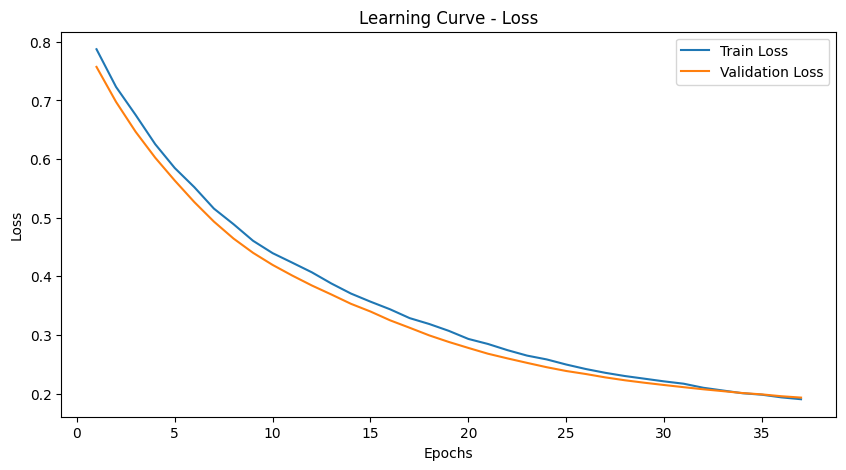

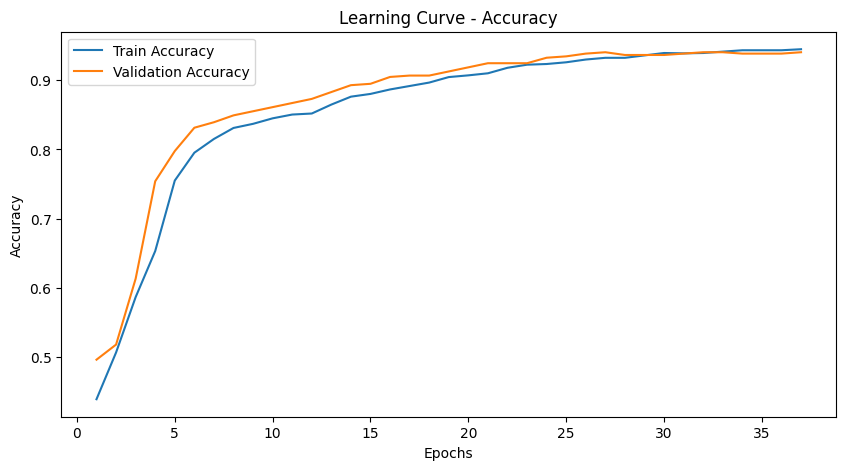

In [17]:
# Plotting learning curve for loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()

# Plotting learning curve for accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')
plt.show()

In [18]:
# Evaluating on Test Data
model.eval()
all_predictions = []
all_targets = []

for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    targets = batch['targets'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# Define target names for the classification report
target_names = ['Negative', 'Positive']

# Generate and print the classification report
print(classification_report(all_targets, all_predictions, target_names=target_names))

Evaluating on Test Data: 100%|█████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.34it/s]

              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95       371
    Positive       0.93      0.92      0.92       258

    accuracy                           0.94       629
   macro avg       0.93      0.93      0.93       629
weighted avg       0.94      0.94      0.94       629



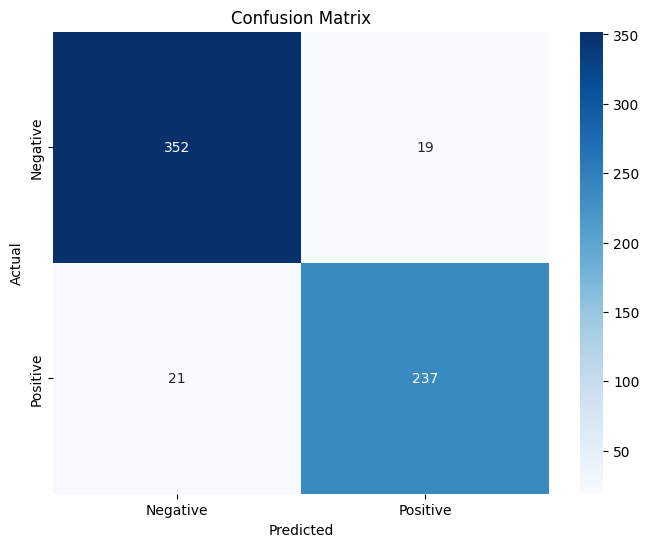

In [19]:
import seaborn as sns

conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Identifikasi False Positives (FP) dan False Negatives (FN)
false_positives = []
false_negatives = []

for i in range(len(all_predictions)):
    if all_predictions[i] == 1 and all_targets[i] == 0:
        false_positives.append((i, test_df.iloc[i]['review']))
    elif all_predictions[i] == 0 and all_targets[i] == 1:
        false_negatives.append((i, test_df.iloc[i]['review']))

# Menampilkan False Positives
print("\nFalse Positives (Predicted Positive, Actual Negative):")
print(f"Total False Positives: {len(false_positives)}")
for idx, review in false_positives:
    print(f"Index: {idx}, Review: {review}")

# Menampilkan False Negatives
print("\nFalse Negatives (Predicted Negative, Actual Positive):")
print(f"Total False Negatives: {len(false_negatives)}")
for idx, review in false_negatives:
    print(f"Index: {idx}, Review: {review}")



False Positives (Predicted Positive, Actual Negative):
Total False Positives: 19
Index: 8, Review: tolong permudah live kasih trafik
Index: 10, Review: tolong aplikasi diinstal
Index: 60, Review: susah hikks
Index: 72, Review: merugikan
Index: 133, Review: bagus
Index: 191, Review: semoga dipermudahkan berjualan sinj
Index: 198, Review: perbaiki bagus aplikasinya aplikasi penghasilan jualan produk aplikasi terima kasih
Index: 205, Review: aplikasi ok
Index: 217, Review: ya mudah mudahan akun bantu bejualan
Index: 246, Review: ausah lakunya kak
Index: 337, Review: daftar bisaãâ
Index: 442, Review: ongkirnya mahal tokped ãåâåãåââãåâåãåââãåâåãåââ
Index: 492, Review: gooooookd
Index: 494, Review: belibet katagori tolong berguna terima kasih
Index: 512, Review: suka
Index: 520, Review: masuk
Index: 524, Review: sih tiktok shop lepas akunãåââž
Index: 530, Review: bermanfaat
Index: 603, Review: masuk

False Negatives (Predicted Negative, Actual Positive):
Total False Negatives: 21
Index: 1, 

In [ ]:
# Function to predict sentiment
def predict_sentiment(review, tokenizer, model, max_len=128):
    model.eval()
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]
    return "Positif" if prediction == 1 else "Negatif"

In [ ]:
# Test the prediction function
example_reviews = [
    "upload produk hasil foto sendiri tapi kena pelanggaran",
    "tampilannya mempermudah pengguna baru"
]

for review in example_reviews:
    sentiment = predict_sentiment(review, tokenizer, model)
    print(f"Review: {review} | Sentiment: {sentiment}")

In [ ]:
# Simpan model
model_dir = "sentiment_model"
model.save_pretrained(model_dir)

# Simpan tokenizer
tokenizer_dir = "sentiment_tokenizer"
tokenizer.save_pretrained(tokenizer_dir)